# Training Super Mario Bros (NES)
---

## Contents

- [Background](#background)
- [Training](#training)
    - [Environment + Architecture](#environment--architecture)
    - [Reward Shaping](#reward-shaping)
        - (Me trying to get it working):
        - [Initial](#reward-shaping---initial)
        - [xscroll reward](#reward-shaping---xscroll-reward)
        - [time scale](#reward-shaping---time-scale)
        - [xscroll smoothing](#reward-shaping---xscroll-smoothing)
        - [Death penalty](#reward-shaping---death-penalty)
        - [Branches (General Model)](#reward-shaping---branches-general-model)
        - (The actual models, what you're probably interested in seeing):
        - [Collector](#reward-shaping---collector)
        - [Speedrunner](#reward-shaping---speedrunner)
- [Results](#results)

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

---
## Background

We ran several experiments with Super Mario Bros (NES), using two personas:
- Collector : Incentivized to get coins
- Speedrunner : Inventivized to get through the level quicker

And using PPO and A2C algorithms.


This uses <a href="https://github.com/Farama-Foundation/stable-retro">stable-retro</a>, a maintained fork of OpenAi's gym-retro which allows classic video game ROMs to be wrapped in a gymnasium environment

### How does stable-retro work?
Stable retro comes with a large directory of defined routes for supported games (I think there's nearly a thousand to use).

```Bash
# Stable retro source code: https://github.com/Farama-Foundation/stable-retro

stable-retro/retro/data/stable/ # Directory containing all games

# Examples:
stable-retro/retro/data/stable/SuperMarioBros-Nes
stable-retro/retro/data/stable/Airstriker-Gensis
```

To import a game for stable-retro to start using, we run the command `python3 -m retro.import {/path/to/game/}`, and the ROM is added for stable-retro to use.

Each directory has definitions for data to use (lives, coins collected, etc) and different scenarios/states (level 1, level 2, etc)

```Bash
# Shortened contents of stable-retro/retro/data/stable/SuperMarioBros-Nes/data.json
{
    "info": { # Main info dict to be referenced in step functions

        "coins": {
            "address": 1886 # Memory address that "coins" are located at in the ROM
            "type: "|u1"
        },

        "lives": {
            "address": 1882,
            "type": "|i1"
        },

    }
}
```

For this experiment, we will mainly be using `xscroll` (calculated value from xscrollHi and xscrollLo), `coins`, and `lives`

---
## Training
### Environment + Architecture
TODO: Explain code/file architecture, what is in each folder, etc

### Reward Shaping

We will start by training a general model with rewards for both movement and collecting coins that can start reliably getting through the first level. Then create two branches for the personas with specialized rewards.

During training, we made sure to keep an eye on the following metrics:

- `approx-kl` - How much the policy changed in the last update. Too high = learning unstable, too low = learning way too slowly
- `entropy_loss` - How "certain" a model is about it's decision-making. Closer to 0.0 = more deterministic.
- `explained_variance` - How good the model is at predicting what to do (this is how I understand it at least)


##### Reward Shaping - Initial
Initially, rewards were only given for collecting coins and beating the level. A penalty was taken away for taking too long to do either of these.

Training for 100,000 timesteps resulted in nothing special:
<center>
    <img style="width: 400px;" src="resources/gifs/notraining.gif"></img>

    rewards for coins and beating the level, no reward for moving forward
</center>

An observation we can make from this is that the model never got any coins nor beat the level during training, so it wasn't encouraged to do anything in particular.

##### Reward Shaping - xscroll reward
We then added a small reward for moving to the right. Each step, the current xscroll is compared to the previous frame's xscroll, and is then rewarded based on the distance travelled:

```Python
# Snippet from configs.rewardwrappers SpeedRewardPersona:

def step(self, action):
        obs, legacy_reward, terminated, truncated, info = self.env.step(action)
        ...
        reward = 0.0
        # -- Reward for moving forward --
        # -- We don't want to penalize backward movement, otherwise mario would get stuck --
        if dx > 0:
            reward += dx * 0.4
        ...
        return obs, reward, terminated, truncated, info 
```

This resulted in the model finally having some incentive to progress through the level:

<center>
    <img style="width: 400px;" src="resources/gifs/100kiterations.gif"></img>

    eval after 100k iterations
</center>

##### Reward Shaping - time scale
The model is still moving way too slowly, so we added time scaling for higher rewards for moving quicker:

```Python
def step(self, action):
        obs, legacy_reward, terminated, truncated, info = self.env.step(action)
        ...
        # -- Added multiplier for time remaining in the level
        # -- Reward gets lower the longer mario takes
        reward += dx * 0.04 * info.get("time")
        ...
        return obs, reward, terminated, truncated, info
```

As a result of this, the agent didn't seem to be getting any further in training. A possible explanation is that the time scale rewarded for **EARLIER** movement, not faster.

Time scaling was taken out for the remainder of the tests.

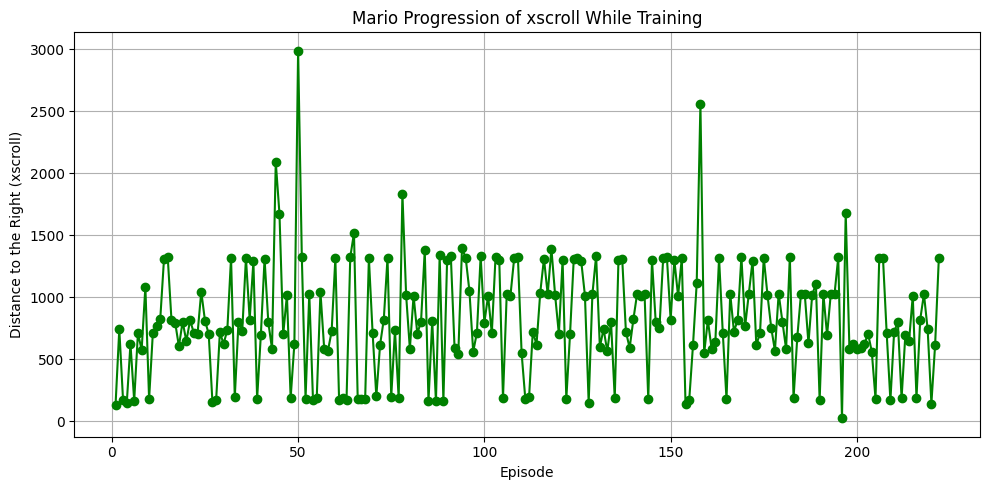

In [11]:
df = pd.read_csv("../logs/previous-tests/ppo_collector_2.csv")
df = df.dropna()
df["episode"] = df["episode"].astype(int)

plt.figure(figsize=(10, 5))
plt.plot(df["episode"], df["xscroll"], marker="o", color="green")
plt.title("Mario Progression of xscroll While Training")
plt.xlabel("Episode")
plt.ylabel("Distance to the Right (xscroll)")
plt.grid(True)
plt.tight_layout()
plt.show()

##### Reward Shaping - xscroll smoothing
The xscroll was then changed to be "smoothed out", meaning a reward would be granted for an average from the past 5 steps:

```Python
def step(self, action):
    obs, legacy_reward, terminated, truncated, info = self.env.step(action)
    ...
    # Only have record of the past 5 steps
    if len(self.progress_history) > 5:
        self.progress_history.pop(0)
    
    # Add current progress to the history window
    progress = info.get("xscroll") - self.last_x
    self.progress_history.append(progress)

    # Get the average of the current 5-step history window
    smooth_reward = np.mean(self.progress_history) * 1.0

    # Add this averaged reward to the current total
    reward += smooth_reward
    ...
    return obs, reward, terminated, truncated, info
```

This would serve to encourage more consistent movement, rather than big rewards for little bursts of movement.

##### Reward Shaping - Death penalty
We then added a death penalty, as the player doesn't seem to care about avoiding hazards during evaluation.

```Python
def step(self, action):
    obs, legacy_reward, terminated, truncated, info = self.env.step(action)
    ...
    # --- Death penalty ---
    current_lives = info.get("lives", self.last_lives)
    if current_lives < self.last_lives:
        reward -= 50  # Big punishment for dying
    ...
    return obs, reward, terminated, truncated, info
```

We quickly realized that the penalty was too large, and the model was too scared of dying that it decided it was best to not move.

<center>
    <img style="width: 400px;" src="resources/gifs/notmoving.gif"></img>

    ppo speedrunner, too large death penalty
</center>

This was recorded after the `entropy_loss` converged from `-5.6` up to `-0.1`. Note that a converged entropy loss doesn't always mean a good thing, just because the agent is confident with an idea doesn't make it a good idea!

We decided to scrap the death penalty for now, as we realized there were more hazards + reasons for mario to die later in the level, and adding the penalty this early into training might discourage the model from getting too far.

##### Reward Shaping - Branches (General Model)
At this point, we decided to try a few times to create a branch of the model to see what could work best. These were initially intended to be used for the speedrunner (hence the model names) but worked very nicely for our general "all-purpose" model.

The following models were trained for ~130 episodes in attempt to find one with an upwards xscroll trend:

**ppo_speedrunner**
- Added death penalty, smoothing on xscroll, removed the coin reward

**ppo_mario_speedrunner_removedclipping**
- Removed reward clipping (no longer set all rewards to -1, 0, 1) to allow for better reward scaling (really should have done this earlier)

**ppo_speedrunner_basic**
- removed smoothing mechanic for xscroll, testing if the smoothing is dampening the rewards

See the plots for these below:

In [12]:
# -- ppo_speedrunner

# (No logs were saved for the training of this model, oops)

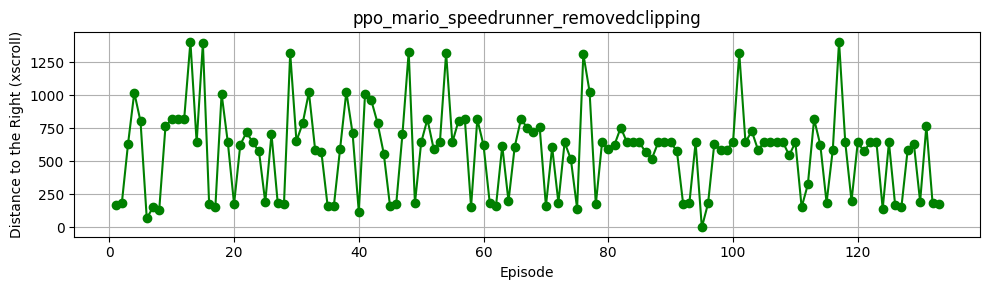

In [13]:
# -- ppo_mario_speedrunner_removedclipping

df = pd.read_csv("../logs/previous-tests/noclipping_speedrunner.csv")
df = df.dropna()
df["episode"] = df["episode"].astype(int)

plt.figure(figsize=(10, 3))
plt.plot(df["episode"], df["xscroll"], marker="o", color="green")
plt.title("ppo_mario_speedrunner_removedclipping")
plt.xlabel("Episode")
plt.ylabel("Distance to the Right (xscroll)")
plt.grid(True)
plt.tight_layout()
plt.show()

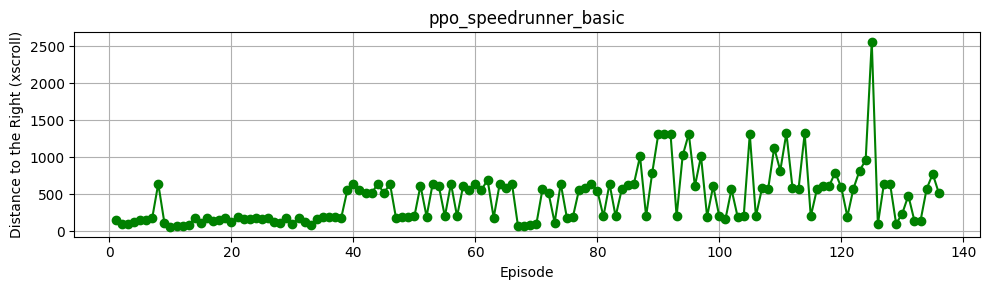

In [14]:
# -- ppo_speedrunner_basic

df = pd.read_csv("../logs/previous-tests/ppo_speedrunner_basic.csv")
df = df.dropna()
df["episode"] = df["episode"].astype(int)

plt.figure(figsize=(10, 3))
plt.plot(df["episode"], df["xscroll"], marker="o", color="green")
plt.title("ppo_speedrunner_basic")
plt.xlabel("Episode")
plt.ylabel("Distance to the Right (xscroll)")
plt.grid(True)
plt.tight_layout()
plt.show()

The step function for ppo_speedrunner_basic was looking to be the best option:

<center>
    <img style="width: 400px;" src="resources/gifs/basic.gif"></img>
    
    ppo_speedrunner_basic
</center>

Once we found a model branch that seemed to be working, we tested changing hparams to see what effect they would have:
- `n_steps`, `128` -> `256`
- `batch_size`, `32` -> `64`
- `ent_coef`, `0.01` -> `0.02`

Adjusting `n_steps` and `batch_size` like this had minimal effects; we later realized that they would need to be MUCH bigger.

Increasing `ent_coef` lowered the agent's confidence slightly, and encouraged more exploration and unconventional movement. 

With this setup, it was nearly time to start training for millions of timesteps. We trained this for a few hundred thousand more just for now to make sure it's on the right track:

<center>
    <img style="width: 400px;" src="resources/gifs/basic_2.gif"></img>
    
    ppo_speedrunner_basic, hparams changed
</center>

##### Reward Shaping - Collector
We created a new branch to train the collector persona, where we added the following adjustments:
- Disabled reward clipping (again, don't auto set all rewards to -1, 0, and 1. We want bigger rewards depending on what the model does)
- Added a huge reward of `100.0` for each coin collected (For reference, moving 1px = `0.02` reward. Beating the level = `250.0` reward)


As a result, we saw the cross entropy loss drop incredibly quickly from `-6.2` to `-0.4`, meaning the model has once again become very confident:

<center>
    <img style="width: 400px;" src="resources/gifs/coincollector_stupid.gif"></img>
</center>

The reward for coins was clearly way too big. The agent completely disregards getting a reward for xscroll, or any exploration. It is also young enough where it's still jumping randomly, and likely has accidentally jumped underneath this box during training. It doesn't know the correlation, it does know that when it stands under this box it sometimes gets a massive reward:

<center>
    <img style="width: 300px;" src="resources/images/birdmeme.PNG"></img>
</center>

I thought this was really neat.

The inflated rewards were corrected:
- Per xscroll (reward per pixel moved forward) = `0.02` -> `0.2` (10x)
- Per Coin = `100.0` -> `50.0` (0.5x)
- Beating Level = `250.0` -> `500.0` (0.5x)

And the following hparams were changed:
- n_steps = `256` -> `2048` (8x)
- batch_size = `64` -> `1024` (16x)
- gamma = `0.995` -> `0.99`
- gae_lambda = `0.99` -> `0.95`

Also, I decided to train with my graphics card instead of my crappy laptop CPU (again, don't know why I didn't do this to begin with)

Training for 5.5M+ timesteps, or 2,500+ episodes:

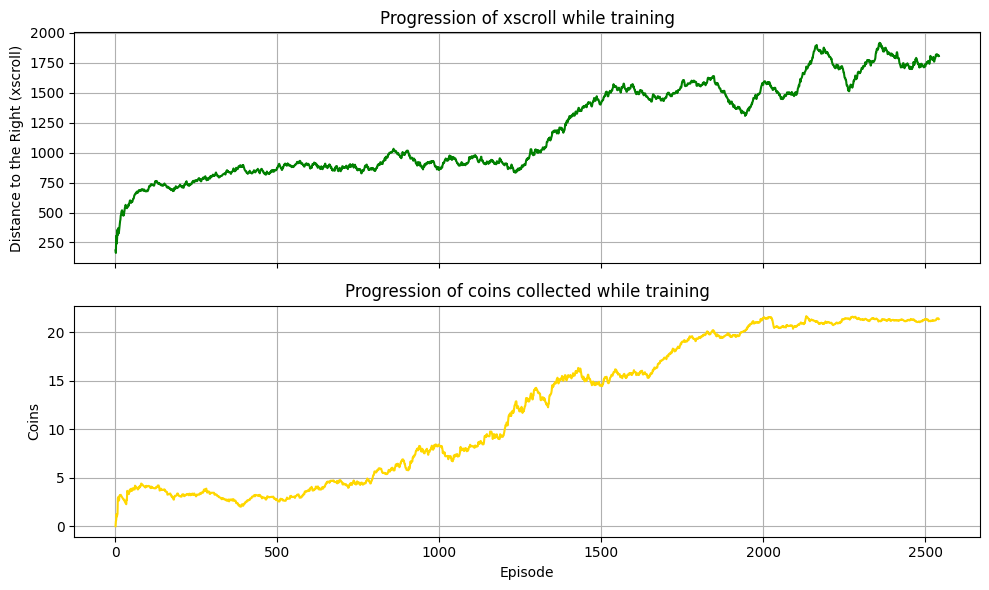

In [15]:
df = pd.read_csv("../logs/ppo_collector.csv").dropna()
df["episode"] = df["episode"].astype(int)

df["xscroll_smooth"] = df["xscroll"].rolling(window=100, min_periods=1).mean()
df["coins_smooth"] = df["coins"].rolling(window=100, min_periods=1).mean()

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(df["episode"], df["xscroll_smooth"], color="green")
axes[0].set_title("Progression of xscroll while training")
axes[0].set_ylabel("Distance to the Right (xscroll)")
axes[0].grid(True)

axes[1].plot(df["episode"], df["coins_smooth"], color="gold")
axes[1].set_title("Progression of coins collected while training")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Coins")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Finally, we are really getting somewhere.

##### Reward Shaping - Speedrunner
We decided to not reinvent the wheel, and actually make a branch of the coin collector model to train the final speedrunner model.

We expected to see a decrease in coins collected and an increase in total xscroll, due to the model branch's new priorities.

The following rewards were adjusted:
- Per xscroll = `0.2` -> `0.4` (2x)
- Per coin = `50.0` -> `5.0` (0.1x)
- Beating level = `500.0` -> `2,000.0` (4x)

The model was then trained for an additional 2M+ timesteps:

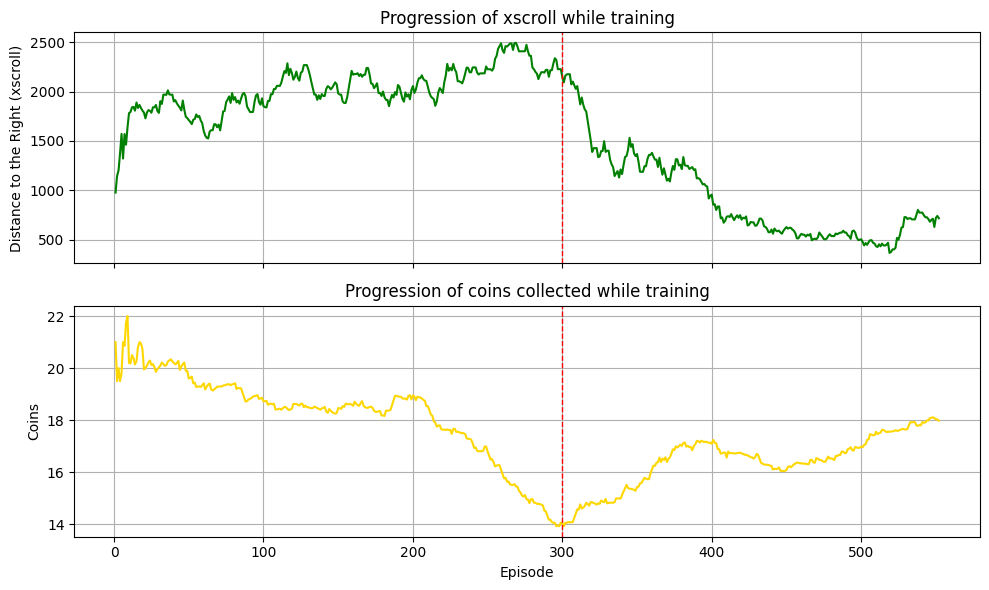

In [16]:
df = pd.read_csv("../logs/ppo_speedrunner.csv").dropna()
df["episode"] = df["episode"].astype(int)

df["xscroll_smooth"] = df["xscroll"].rolling(window=25, min_periods=1).mean()
df["coins_smooth"] = df["coins"].rolling(window=100, min_periods=1).mean()

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
vline_x = 300

axes[0].plot(df["episode"], df["xscroll_smooth"], color="green")
axes[0].axvline(x=vline_x, color="red", linestyle="--", linewidth=1)
axes[0].set_title("Progression of xscroll while training")
axes[0].set_ylabel("Distance to the Right (xscroll)")
axes[0].grid(True)

axes[1].plot(df["episode"], df["coins_smooth"], color="gold")
axes[1].axvline(x=vline_x, color="red", linestyle="--", linewidth=1)
axes[1].set_title("Progression of coins collected while training")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Coins")
axes[1].grid(True)

plt.tight_layout()
plt.show()

NOTE: The red line is approximately when mario started making it to level 2! Whenever he does, xscroll gets **reset back to zero**. This means that the steep decrease in xscroll observed over time tells us that more and more agents were making it to the second level while training.

##### Reward Shaping - Collector (Using A2C)
Finally, we trained the collector persona using the A2C algorithm with a CNN policy.

The reward wrapper was left unchanged, however the following hparams were changed for the new algorithm.
- `learning_rate` = `2.5e-4` -> `5e-4`
- `n_steps` = `2048` -> `32`
- `gae_lambda` = `0.95` -> `1.0`

This was trained for 10M+ timesteps.

## Results

You can try out the three experiments for yourself:
```Bash
cd /mario/
python3 -m src.eval_mario
```

To change which algorithm/persona is evaluated, change the configuration variables near the top of the <a href="../src/eval_mario.py">script</a>:
```Python
MODEL_NAME = "filename for trained model" # "ppo_collector", "ppo_speedrunner", "a2c_collector"
SELETED_ALGO = "algorithm to evaluate" # "A2C", "PPO"
SELECTED_PERSONA = "persona to evaluate" # "speedrunner", "collector"
```

#### Speedrunner - PPO

Rewards:
- `0.4` per xscroll
- `-0.05` penalty per frame
- `5.0` per coin
- `2,000.0` For beating the level

Hparams
- Learning rate = `2.5e-4`
- N Steps = `2048`
- Batch Size = `1024`
- N Epochs = `4`
- Gamma = `0.99`
- Gae Lambda = `0.95`
- Ent. Coeff. = `0.01`

<center>
    <img style="width: 400px;" src="resources/gifs/ppo_speedrunner_final.gif"></img>
</center>

#### Collector - PPO

Rewards:
- `0.2` per xscroll
- `50.0` per coin
- `500.0` For beating the level

Hparams
- Learning rate = `2.5e-4`
- N Steps = `2048`
- Batch Size = `1024`
- N Epochs = `4`
- Gamma = `0.99`
- Gae Lambda = `0.95`
- Ent. Coeff. = `0.01`

<center>
    <img style="width: 400px;" src="resources/gifs/ppo_collector_final.gif"></img>
</center>

#### Collector - A2C

Rewards:
- `0.2` per xscroll
- `50.0` per coin
- `500.0` For beating the level

Hparams
- Learning rate = `5e-4`
- N Steps = `32`
- Gamma = `0.99`
- Gae Lambda = `1.0`
- Ent. Coeff. = `0.01`
- Vf Coeff = `0.5`
- Max grad. norm = `0.5`

<center>
    <img style="width: 400px;" src="resources/gifs/a2c_collector_final.gif"></img>
</center>